In [98]:
%%capture
!uv pip install pandas safetensors torch scipy tqdm torchvision torch torchinfo timm tensorboard

In [100]:
import os, inspect

from datetime import datetime
from typing import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torchinfo import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from safetensors.torch import save_model, load_model

In [104]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## test set exploration

Total samples in CSV: 10000


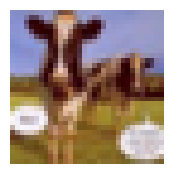

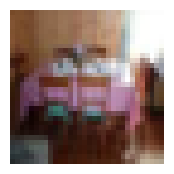

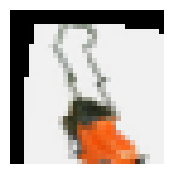

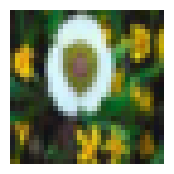

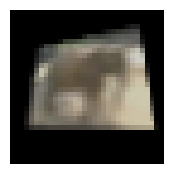

In [105]:
csv_path = 'test.csv'
df = pd.read_csv(csv_path)

print(f'Total samples in CSV: {len(df)}')


# Function to reverse the normalization
def unnormalize(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return tensor


CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

# Select a few samples to display (e.g., first 5)
num_samples = 5
samples = df.sample(n=num_samples)  # Randomly select samples for diversity

# Iterate through the selected samples and display images
for index, row in samples.iterrows():
  # Extract pixel data and convert to numpy array
  pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)

  # Reshape to (3, 32, 32)
  image = pixel_data.reshape(3, 32, 32)

  # Convert to torch tensor
  image_tensor = torch.tensor(image)

  # Reverse the normalization
  image_tensor = unnormalize(image_tensor, CIFAR100_MEAN, CIFAR100_STD)

  # Clip the values to [0, 1] range
  image_tensor = torch.clamp(image_tensor, 0, 1)

  # Convert to numpy array and transpose to (32, 32, 3) for plotting
  image_np = image_tensor.numpy().transpose(1, 2, 0)

  # Convert to PIL Image for better handling (optional)
  image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

  # Display the image using matplotlib
  plt.figure(figsize=(2, 2))
  plt.imshow(image_pil)
  plt.axis('off')

---

## implementation

We will use EfficientNet V2 described in [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298v3)

Training configuration:
- criterion: `nn.CrossEntropyLoss()`
- optimizer: `optim.AdamW` with `lr=0.001` and added weight decay
- scheduler: `CosineAnnealingLR` with `T_max=30`

### hyperparameters

In [86]:
# Define CIFAR-100 mean and std
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

# Hyperparameters
num_epochs = 30
lr = 0.001
weight_decay = 1e-4
batch_size = 128
model_prefix = f'efficientnet_v2_{lr}_{num_epochs}'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ncols = 100

### helpers

In [81]:
# CIFAR-100 dataset (download and create DataLoader)
def get_dataloaders(batch_size):
  transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
  ])

  transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD)])

  train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  return train_loader, test_loader


def _holistic_patch(model, num_features=100):
  model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_features)


# Load EfficientNetV2 model
def init_model(variants: Literal['S', 'M', 'L'] = 'S', patch=_holistic_patch):
  if variants == 'S':
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
  elif variants == 'M':
    model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
  elif variants == 'L':
    model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
  patch(model)
  model.variants = variants
  model = model.to(device)
  return model


# Load model if exists
def load_checkpoint(filepath, model=None, variants='S'):
  if model is None:
    model = init_model(variants)
  load_model(model, filepath)
  model.eval()
  return model


# Save model to safetensors
def save_checkpoint(model, accuracy, model_prefix, basedir='./model'):
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  os.makedirs(basedir, exist_ok=True)

  variants = 'default'
  if hasattr(model, 'variants'):
    variants = model.variants

  filepath = os.path.join(basedir, f'{model_prefix}_{variants}_{accuracy:.2f}_{timestamp}.safetensors')
  save_model(model, filepath)
  print(f'Model checkpoint saved to {filepath}.')

In [87]:
# Train the model
def train(model, train_loader, criterion, optimizer, scheduler, num_epochs, *, ncols=100):
  best_accuracy = 0.0
  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(enumerate(train_loader), total=len(train_loader), ncols=ncols) as bar:
      for i, (images, labels) in bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        bar.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
        bar.set_postfix(loss=loss.item())

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    # Evaluate the model on test set after each epoch
    test_acc = evaluate(model, test_loader)
    if test_acc > best_accuracy:
      best_accuracy = test_acc
      save_checkpoint(model, best_accuracy, model_prefix)

  # Plotting training history
  plot_training_history(train_losses, train_accuracies)


# Evaluate the model
def evaluate(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')
  return accuracy


# Plot training history
def plot_training_history(train_losses, train_accuracies):
  plt.figure(figsize=(12, 5))

  # Plot training loss
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.legend()

  # Plot training accuracy
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training Accuracy over Epochs')
  plt.legend()

  plt.show()


def validations(model, test_loader, classes, num_examples=16):
  model.eval()
  SAMPLES, PREDS, LABELS = [], [], []

  with torch.no_grad():
    for _ in range(num_examples):
      idx = np.random.randint(len(test_loader.dataset))
      sample_image, actual_label = test_loader.dataset[idx]
      sample_image = sample_image.unsqueeze(0).to(device)
      SAMPLES.append(sample_image.squeeze(0))
      LABELS.append(actual_label)

      output = F.softmax(model(sample_image), dim=-1)
      pred_values, pred_labels = output.max(-1)
      PREDS.append(round(float(pred_values), 4))
      LABELS.append(int(pred_labels))

  fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(21, 19))
  i = 0
  for R in range(4):
    for C in range(4):
      image_np = SAMPLES[i].cpu().numpy().transpose(1, 2, 0)
      image_np = image_np * np.array((0.2675, 0.2565, 0.2761)) + np.array((0.5071, 0.4867, 0.4408))  # Unnormalize
      image_np = np.clip(image_np, 0, 1)
      ax[R, C].imshow(image_np)
      ax[R, C].set_title('Actual: ' + classes[LABELS[i]], fontsize=16).set_color('k')
      ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=25).set_color('m')
      if LABELS[i] == LABELS[i]:
        ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('b')
      else:
        ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('r')
      ax[R, C].set_xticks([])
      ax[R, C].set_yticks([])
      i += 1

  plt.show()

### training loop

In [83]:
# Training parameters
train_loader, test_loader = get_dataloaders(batch_size)
model = init_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler.step(epoch + i / len(train_loader))

Files already downloaded and verified
Files already downloaded and verified


In [84]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 100]                 --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 24, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 24, 112, 112]        648
│    │    └─BatchNorm2d: 3-2                            [32, 24, 112, 112]        48
│    │    └─SiLU: 3-3                                   [32, 24, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 24, 112, 112]        --
│    │    └─FusedMBConv: 3-4                            [32, 24, 112, 112]        5,232
│    │    └─FusedMBConv: 3-5                            [32, 24, 112, 112]        5,232
│    └─Sequential: 2-3                                  [32, 48, 56, 56]          --
│    │    └─FusedMBConv: 3-6                         

Epoch [1/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 18.87it/s, loss=2.13]

Epoch [1/30], Loss: 2.8834, Accuracy: 28.73%


Test Accuracy: 46.47%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_46.47_20241204_055710.safetensors.


Epoch [2/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 18.89it/s, loss=1.88]

Epoch [2/30], Loss: 1.8471, Accuracy: 49.24%


Test Accuracy: 54.34%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_54.34_20241204_055733.safetensors.


Epoch [3/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.33it/s, loss=1.54]

Epoch [3/30], Loss: 1.5800, Accuracy: 55.52%


Test Accuracy: 56.91%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_56.91_20241204_055755.safetensors.


Epoch [4/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.13it/s, loss=1.23]

Epoch [4/30], Loss: 1.4543, Accuracy: 58.88%


Test Accuracy: 57.93%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_57.93_20241204_055817.safetensors.


Epoch [5/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 18.85it/s, loss=1.22]


Epoch [5/30], Loss: 1.5281, Accuracy: 57.20%
Test Accuracy: 55.93%


Epoch [6/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.24it/s, loss=1.36]

Epoch [6/30], Loss: 1.4083, Accuracy: 60.09%


Test Accuracy: 57.96%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_57.96_20241204_055901.safetensors.


Epoch [7/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.42it/s, loss=1.63]

Epoch [7/30], Loss: 1.3777, Accuracy: 60.64%


Test Accuracy: 59.71%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_59.71_20241204_055922.safetensors.


Epoch [8/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.30it/s, loss=1.03]

Epoch [8/30], Loss: 1.2605, Accuracy: 63.63%


Test Accuracy: 60.57%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_60.57_20241204_055944.safetensors.


Epoch [9/30]: 100%|████████████████████████████████████| 391/391 [00:20<00:00, 19.28it/s, loss=1.22]

Epoch [9/30], Loss: 1.1553, Accuracy: 66.36%


Test Accuracy: 62.68%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_62.68_20241204_060006.safetensors.


Epoch [10/30]: 100%|███████████████████████████████████| 391/391 [00:19<00:00, 19.69it/s, loss=1.03]

Epoch [10/30], Loss: 1.0535, Accuracy: 68.79%


Test Accuracy: 63.15%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_63.15_20241204_060027.safetensors.


Epoch [11/30]: 100%|███████████████████████████████████| 391/391 [00:19<00:00, 20.42it/s, loss=1.35]

Epoch [11/30], Loss: 1.0831, Accuracy: 68.05%


Test Accuracy: 60.27%


Epoch [12/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 20.40it/s, loss=0.974]

Epoch [12/30], Loss: 1.0329, Accuracy: 69.42%


Test Accuracy: 61.81%


Epoch [13/30]: 100%|███████████████████████████████████| 391/391 [00:19<00:00, 19.64it/s, loss=1.01]

Epoch [13/30], Loss: 0.9854, Accuracy: 70.45%


Test Accuracy: 62.14%


Epoch [14/30]: 100%|███████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s, loss=1.24]

Epoch [14/30], Loss: 0.9922, Accuracy: 70.37%


Test Accuracy: 62.25%


Epoch [15/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 20.14it/s, loss=0.908]

Epoch [15/30], Loss: 0.9704, Accuracy: 70.83%


Test Accuracy: 63.93%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_63.93_20241204_060212.safetensors.


Epoch [16/30]: 100%|███████████████████████████████████| 391/391 [00:20<00:00, 19.28it/s, loss=0.92]

Epoch [16/30], Loss: 0.8690, Accuracy: 73.49%


Test Accuracy: 63.98%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_63.98_20241204_060234.safetensors.


Epoch [17/30]: 100%|███████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s, loss=1.74]

Epoch [17/30], Loss: 0.8870, Accuracy: 73.34%


Test Accuracy: 54.42%


Epoch [18/30]: 100%|████████████████████████████████████| 391/391 [00:19<00:00, 19.98it/s, loss=1.1]

Epoch [18/30], Loss: 0.8841, Accuracy: 72.97%


Test Accuracy: 65.28%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_65.28_20241204_060316.safetensors.


Epoch [19/30]: 100%|███████████████████████████████████| 391/391 [00:20<00:00, 19.09it/s, loss=1.15]

Epoch [19/30], Loss: 0.9878, Accuracy: 70.96%


Test Accuracy: 62.12%


Epoch [20/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 20.34it/s, loss=0.879]

Epoch [20/30], Loss: 0.8336, Accuracy: 74.27%


Test Accuracy: 63.74%


Epoch [21/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 19.57it/s, loss=0.766]

Epoch [21/30], Loss: 0.8222, Accuracy: 74.87%


Test Accuracy: 63.87%


Epoch [22/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 19.92it/s, loss=0.689]

Epoch [22/30], Loss: 0.7690, Accuracy: 76.14%


Test Accuracy: 64.36%


Epoch [23/30]: 100%|██████████████████████████████████| 391/391 [00:20<00:00, 19.30it/s, loss=0.573]

Epoch [23/30], Loss: 0.6651, Accuracy: 79.00%


Test Accuracy: 65.04%


Epoch [24/30]: 100%|██████████████████████████████████| 391/391 [00:20<00:00, 19.19it/s, loss=0.595]

Epoch [24/30], Loss: 0.5930, Accuracy: 81.15%


Test Accuracy: 65.31%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_65.31_20241204_060524.safetensors.


Epoch [25/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s, loss=0.703]

Epoch [25/30], Loss: 0.5594, Accuracy: 82.23%


Test Accuracy: 65.64%
Model checkpoint saved to ./model/efficientnet_v2_0.001_30_65.64_20241204_060546.safetensors.


Epoch [26/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 19.82it/s, loss=0.704]

Epoch [26/30], Loss: 0.5299, Accuracy: 83.07%


Test Accuracy: 64.36%


Epoch [27/30]: 100%|██████████████████████████████████| 391/391 [00:20<00:00, 19.23it/s, loss=0.569]


Epoch [27/30], Loss: 0.6660, Accuracy: 79.24%
Test Accuracy: 64.55%


Epoch [28/30]: 100%|██████████████████████████████████| 391/391 [00:20<00:00, 19.47it/s, loss=0.468]

Epoch [28/30], Loss: 0.5046, Accuracy: 83.70%


Test Accuracy: 64.99%


Epoch [29/30]: 100%|██████████████████████████████████| 391/391 [00:20<00:00, 19.35it/s, loss=0.502]

Epoch [29/30], Loss: 0.5025, Accuracy: 83.93%


Test Accuracy: 64.78%


Epoch [30/30]: 100%|██████████████████████████████████| 391/391 [00:19<00:00, 19.59it/s, loss=0.675]

Epoch [30/30], Loss: 0.5079, Accuracy: 83.70%


Test Accuracy: 64.18%


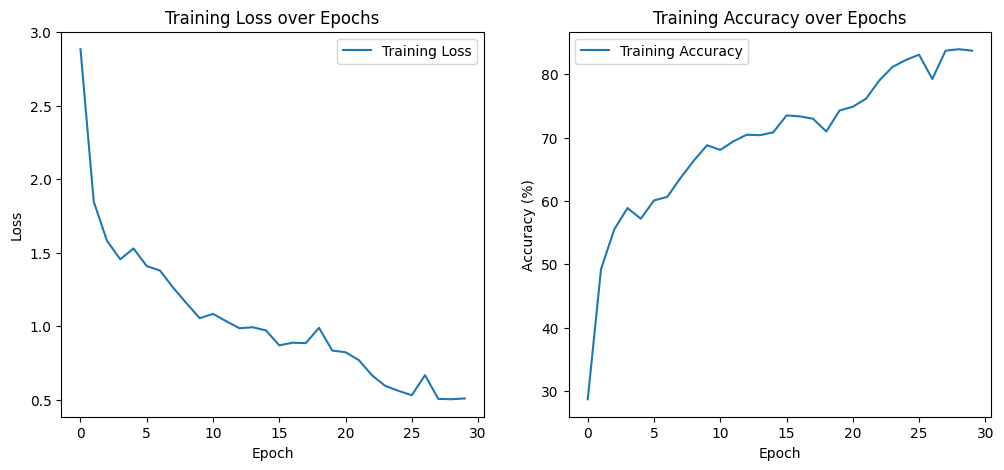

Test Accuracy: 64.18%


64.18

In [20]:
# first pass
train(model, train_loader, criterion, optimizer, scheduler, num_epochs, ncols=ncols)
evaluate(model, test_loader)

In [58]:
%%capture
load_checkpoint('./model/efficientnet_v2_0.001_30_65.64_20241204_060546.safetensors', model)

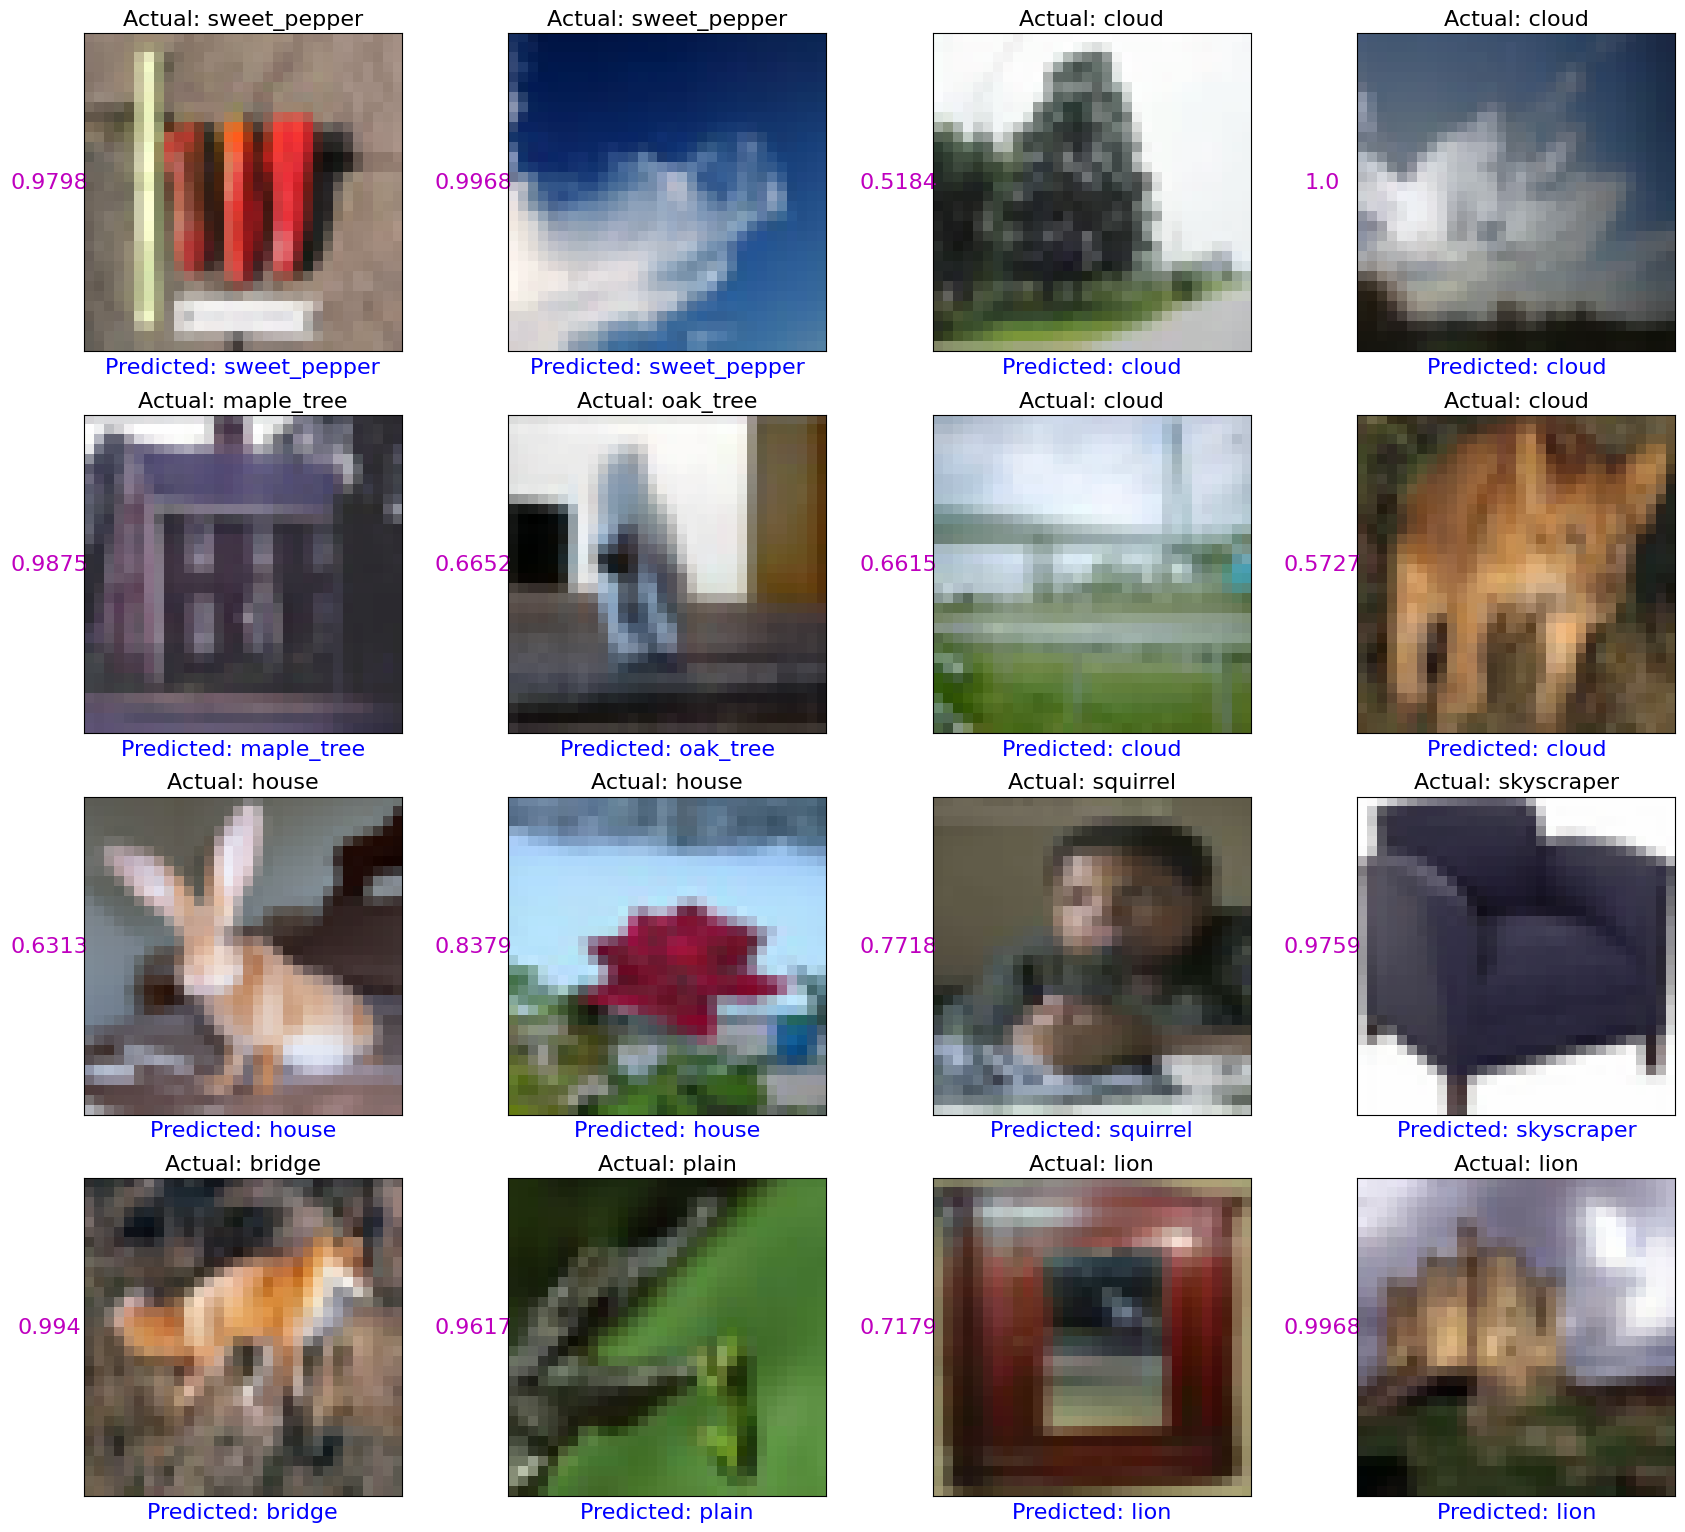

In [59]:
validations(model, test_loader, classes=test_loader.dataset.classes, num_examples=20)

---
maybe we need to patch here?

In [95]:
## hmm, we might need to patch efficientnet such that it works with CIFAR100, let's just use a bigger variants for now
model = init_model(variants='L')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

In [89]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 100]                 --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        --
│    │    └─FusedMBConv: 3-4                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-5                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-6                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-7                      

Epoch [1/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.81it/s, loss=3.45]

Epoch [1/30], Loss: 4.0097, Accuracy: 11.31%


Test Accuracy: 30.47%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_30.47_20241204_070203.safetensors.


Epoch [2/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.80it/s, loss=2.85]

Epoch [2/30], Loss: 2.9738, Accuracy: 32.93%


Test Accuracy: 46.06%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_46.06_20241204_070247.safetensors.


Epoch [3/30]: 100%|████████████████████████████████████| 391/391 [00:40<00:00,  9.61it/s, loss=2.66]

Epoch [3/30], Loss: 2.5264, Accuracy: 45.25%


Test Accuracy: 52.72%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_52.72_20241204_070331.safetensors.


Epoch [4/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.79it/s, loss=2.26]

Epoch [4/30], Loss: 2.2879, Accuracy: 52.32%


Test Accuracy: 56.63%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_56.63_20241204_070415.safetensors.


Epoch [5/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.80it/s, loss=1.98]

Epoch [5/30], Loss: 2.1588, Accuracy: 56.12%


Test Accuracy: 57.75%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_57.75_20241204_070459.safetensors.


Epoch [6/30]: 100%|████████████████████████████████████| 391/391 [00:40<00:00,  9.71it/s, loss=2.61]

Epoch [6/30], Loss: 2.2598, Accuracy: 53.50%


Test Accuracy: 58.20%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_58.20_20241204_070543.safetensors.


Epoch [7/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.80it/s, loss=2.22]

Epoch [7/30], Loss: 2.1071, Accuracy: 58.21%


Test Accuracy: 60.86%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_60.86_20241204_070627.safetensors.


Epoch [8/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.78it/s, loss=2.28]

Epoch [8/30], Loss: 1.9694, Accuracy: 62.34%


Test Accuracy: 62.56%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_62.56_20241204_070711.safetensors.


Epoch [9/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.80it/s, loss=1.94]

Epoch [9/30], Loss: 1.8575, Accuracy: 65.80%


Test Accuracy: 63.88%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_63.88_20241204_070755.safetensors.


Epoch [10/30]: 100%|███████████████████████████████████| 391/391 [00:40<00:00,  9.76it/s, loss=1.77]

Epoch [10/30], Loss: 1.7592, Accuracy: 68.92%


Test Accuracy: 65.95%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_65.95_20241204_070839.safetensors.


Epoch [11/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.75]

Epoch [11/30], Loss: 1.6733, Accuracy: 71.67%


Test Accuracy: 66.91%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_66.91_20241204_070923.safetensors.


Epoch [12/30]: 100%|███████████████████████████████████| 391/391 [00:40<00:00,  9.71it/s, loss=1.54]

Epoch [12/30], Loss: 1.5973, Accuracy: 74.06%


Test Accuracy: 67.40%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_67.40_20241204_071007.safetensors.


Epoch [13/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.58]

Epoch [13/30], Loss: 1.5332, Accuracy: 76.35%


Test Accuracy: 68.09%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_68.09_20241204_071051.safetensors.


Epoch [14/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.80it/s, loss=1.43]

Epoch [14/30], Loss: 1.4983, Accuracy: 77.50%


Test Accuracy: 68.31%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_68.31_20241204_071135.safetensors.


Epoch [15/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.66]

Epoch [15/30], Loss: 1.4736, Accuracy: 78.30%


Test Accuracy: 68.24%


Epoch [16/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.88it/s, loss=1.61]

Epoch [16/30], Loss: 1.6510, Accuracy: 72.43%


Test Accuracy: 65.32%


Epoch [17/30]: 100%|███████████████████████████████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.84]

Epoch [17/30], Loss: 1.6160, Accuracy: 73.48%


Test Accuracy: 66.85%


Epoch [18/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.97it/s, loss=1.71]

Epoch [18/30], Loss: 1.5720, Accuracy: 75.07%


Test Accuracy: 67.30%


Epoch [19/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00, 10.02it/s, loss=1.5]

Epoch [19/30], Loss: 1.5090, Accuracy: 77.10%


Test Accuracy: 67.50%


Epoch [20/30]: 100%|███████████████████████████████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.64]

Epoch [20/30], Loss: 1.4539, Accuracy: 78.84%


Test Accuracy: 68.77%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_68.77_20241204_071553.safetensors.


Epoch [21/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00, 10.02it/s, loss=1.65]

Epoch [21/30], Loss: 1.4045, Accuracy: 80.70%


Test Accuracy: 69.15%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_69.15_20241204_071636.safetensors.


Epoch [22/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.32]

Epoch [22/30], Loss: 1.3451, Accuracy: 82.60%


Test Accuracy: 69.28%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_69.28_20241204_071719.safetensors.


Epoch [23/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00, 10.01it/s, loss=1.33]

Epoch [23/30], Loss: 1.2962, Accuracy: 84.46%


Test Accuracy: 69.41%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_69.41_20241204_071802.safetensors.


Epoch [24/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.88it/s, loss=1.16]

Epoch [24/30], Loss: 1.2591, Accuracy: 85.63%


Test Accuracy: 69.81%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_69.81_20241204_071846.safetensors.


Epoch [25/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.95it/s, loss=1.27]

Epoch [25/30], Loss: 1.2132, Accuracy: 87.36%


Test Accuracy: 70.09%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_70.09_20241204_071929.safetensors.


Epoch [26/30]: 100%|████████████████████████████████████| 391/391 [00:40<00:00,  9.68it/s, loss=1.2]

Epoch [26/30], Loss: 1.1713, Accuracy: 88.86%


Test Accuracy: 70.34%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_70.34_20241204_072014.safetensors.


Epoch [27/30]: 100%|████████████████████████████████████| 391/391 [00:39<00:00,  9.84it/s, loss=1.2]

Epoch [27/30], Loss: 1.1378, Accuracy: 90.01%


Test Accuracy: 70.62%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_70.62_20241204_072057.safetensors.


Epoch [28/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.88it/s, loss=1.22]

Epoch [28/30], Loss: 1.1092, Accuracy: 91.17%


Test Accuracy: 70.80%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_70.80_20241204_072141.safetensors.


Epoch [29/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.14]

Epoch [29/30], Loss: 1.0898, Accuracy: 91.78%


Test Accuracy: 70.73%


Epoch [30/30]: 100%|███████████████████████████████████| 391/391 [00:39<00:00,  9.91it/s, loss=1.12]

Epoch [30/30], Loss: 1.0666, Accuracy: 92.70%


Test Accuracy: 71.09%
Model checkpoint saved to ./model/efficientnet_v2_0.01_30_L_71.09_20241204_072307.safetensors.


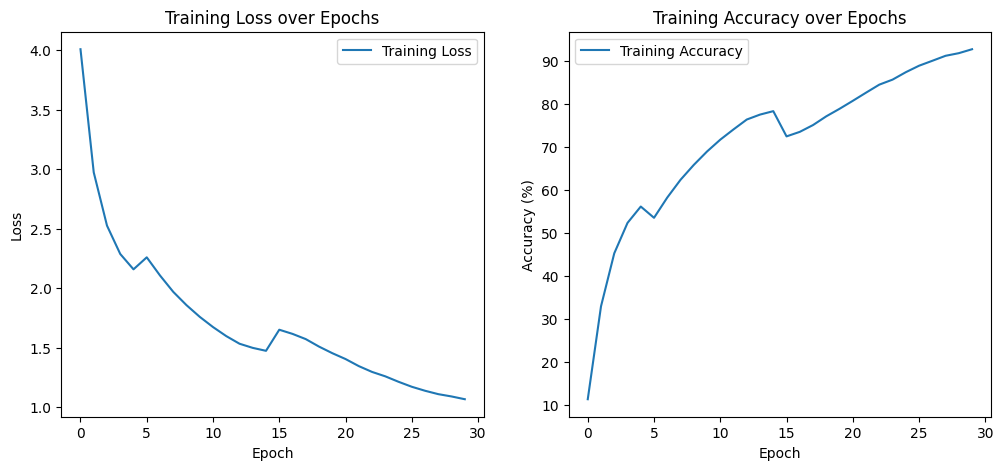

Test Accuracy: 71.09%


71.09

In [90]:
# second pass with patched
train(model, train_loader, criterion, optimizer, scheduler, num_epochs, ncols=ncols)
evaluate(model, test_loader)

---
## finals for submission

In [94]:
csv_path = 'test.csv'
df = pd.read_csv(csv_path)

test_images = []
for _, row in df.iterrows():
  pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)
  image = pixel_data.reshape(3, 32, 32)
  image_tensor = torch.tensor(image)
  test_images.append(image_tensor)

test_images = torch.stack(test_images)

# Predictions on custom test set
model.eval()
custom_preds = []
with torch.no_grad():
  test_images = test_images.to(device)
  for i in range(0, len(test_images), batch_size):
    batch_images = test_images[i : i + batch_size]
    outputs = model(batch_images)
    _, predicted = torch.max(outputs.data, 1)
    custom_preds.extend(predicted.cpu().numpy())

# Formatting predictions as required
submission = pd.DataFrame({'ID': df['ID'], 'LABEL': custom_preds})
submission.to_csv('submission.csv', index=False)
print('Predictions saved to submission.csv')

Predictions saved to submission.csv
